# Text Classification of StackOverflow using BiLSTM RNNs with deep self-attention

In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

import sys
import os
import parent_modules

import warnings
import sklearn.exceptions
import talos as ta

from os import pardir, getcwd
from os.path import join, abspath
from definitions import *

warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

from definitions import TALOS_DIR
from app.preprocessing import (
    load_dataset,
    load_embeddings,
    preprocess_data,
    save_embeddings_matrix,
)
from app.models import load_bi_lstm_model, find_best_model_over_scan_logs
from app.metrics import *

# Comment out In case of Testing use only a set of the tags as dataset
RUN_STATE = "testing"

# Comment out In case of Production use all the tags of the dataset
# RUN_STATE = 'production'

Using TensorFlow backend.


<IPython.core.display.Javascript object>

## Preprocessing for the loaded Dataset

1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*

In [2]:
data, test_data = load_dataset(load_from_pickle=False, minified=True)
classes_counts = data["label"].value_counts().where(lambda cls: cls > 0).dropna()
Classes = list(classes_counts.index)
Nclasses = len(Classes)
print(classes_counts, Classes, Nclasses)

__label__0     3373
__label__2     1426
__label__3      840
__label__4      639
__label__1      344
__label__10     301
__label__14     196
__label__11     194
__label__12     179
__label__13     124
__label__5      108
__label__8       73
__label__9       68
__label__6       56
__label__7       11
Name: label, dtype: int64 ['__label__0', '__label__2', '__label__3', '__label__4', '__label__1', '__label__10', '__label__14', '__label__11', '__label__12', '__label__13', '__label__5', '__label__8', '__label__9', '__label__6', '__label__7'] 15


<IPython.core.display.Javascript object>

> Download and the fasttext vocabulary from [here](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz) and add to *data/fasttext_dir/* folder

In [3]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev
embeddings_voc, embeddings_vec = load_embeddings(load_from_pickle=False)
model_data = preprocess_data(data, "label", "post", cv_split_dev=0.2, minified=True)
embeddings_matrix_path = save_embeddings_matrix(
    embeddings_voc, embeddings_vec, model_data["words_index"]
)

<IPython.core.display.Javascript object>

## Models Definition and Hyperparameter Tuning

> Below it will be defined, trained and evaluate the 2 models of RNNs the first with a unistack RNN with BiLSTM and MLP on top of it and the second with a multistack RNN with BiLSTM and MLP on top of it. 
The hyperparameter tuning is implemented throw the Talos library and will calculate the best configuration for each of the 2 models.

### UniStacked RNN with BiLSTM

In [4]:
###### Production configuration
rnn_deep_lstm_config = {
    "model_type": ["keras_deep_LSTM_model"],
    "embedding_dim": [embeddings_vec.shape[1]],
    "lstm_size": [200],
    "class_weight": [model_data["class_weight"]],
    "dense": [300],
    "embeddings_matrix_path": [embeddings_matrix_path],
    "visualize_process": [True],
    "with_early_stoping": [True],
    "multistack_run": [False],
    "early_stopping": [True],
    "early_stopping_config__monitor": ["val_loss"],
    "early_stopping_config__min_delta": [0],
    "early_stopping_config__patience": [5],
    "early_stopping_config__mode": ["min"],
    "embeddings_dropout": [0.2],
    "var_dropout": [0.1, 0.2],
    "mlp_dropout": [0.2],
    "mlp_activation": ["softmax"],
    "rnn_activation": ["relu", "tanh"],
    "optimizer": ["Nadam", "Adam"],
    "batch_size": [32, 64],
    "epochs": [5 if RUN_STATE == "testing" else 10],
}

<IPython.core.display.Javascript object>

In [5]:
TALOS_LSTM_DEEP_LOG_FILENAME = 'talos_logs_bilstm'
if RUN_STATE == 'testing': 
    TALOS_LSTM_DEEP_LOG_FILENAME += '_test'
# talos_lstm_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_LOG_FILENAME)

history_model = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_config,
                        fraction_limit=0.1,
                        print_params=True,
                        seed=(123),
                        experiment_name=TALOS_LSTM_DEEP_LOG_FILENAME
                        )


  0%|          | 0/3 [00:00<?, ?it/s]

{'batch_size': 64, 'class_weight': {0: 1.1758, 2: 2.7812, 3: 4.7214, 4: 6.2066, 1: 11.5291, 10: 13.1761, 14: 20.2347, 11: 20.4433, 12: 22.1564, 13: 31.9839, 5: 36.7222, 8: 54.3288, 9: 58.3235, 6: 70.8214, 7: 360.5455}, 'dense': 300, 'early_stopping': True, 'early_stopping_config__min_delta': 0, 'early_stopping_config__mode': 'min', 'early_stopping_config__monitor': 'val_loss', 'early_stopping_config__patience': 5, 'embedding_dim': 300, 'embeddings_dropout': 0.2, 'embeddings_matrix_path': 'fasstex_dir/embeddings-matrix-pickle', 'epochs': 5, 'lstm_size': 200, 'mlp_activation': 'softmax', 'mlp_dropout': 0.2, 'model_type': 'keras_deep_LSTM_model', 'multistack_run': False, 'optimizer': 'Adam', 'rnn_activation': 'relu', 'var_dropout': 0.1, 'visualize_process': True, 'with_early_stoping': True}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)            


Epoch 00001: val_loss improved from inf to 3.52190, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.19145, saving model to keras_deep_LSTM_model



Epoch 00002: val_loss did not improve from 3.52190

Epoch 00002: val_f1 improved from 0.19145 to 0.21082, saving model to keras_deep_LSTM_model



Epoch 00003: val_loss improved from 3.52190 to 3.18372, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.21082 to 0.25572, saving model to keras_deep_LSTM_model



Epoch 00004: val_loss did not improve from 3.18372

Epoch 00004: val_f1 improved from 0.25572 to 0.26654, saving model to keras_deep_LSTM_model


 33%|███▎      | 1/3 [29:23<58:47, 1763.91s/it]


Epoch 00005: val_loss did not improve from 3.18372

Epoch 00005: val_f1 did not improve from 0.26654

{'batch_size': 64, 'class_weight': {0: 1.1758, 2: 2.7812, 3: 4.7214, 4: 6.2066, 1: 11.5291, 10: 13.1761, 14: 20.2347, 11: 20.4433, 12: 22.1564, 13: 31.9839, 5: 36.7222, 8: 54.3288, 9: 58.3235, 6: 70.8214, 7: 360.5455}, 'dense': 300, 'early_stopping': True, 'early_stopping_config__min_delta': 0, 'early_stopping_config__mode': 'min', 'early_stopping_config__monitor': 'val_loss', 'early_stopping_config__patience': 5, 'embedding_dim': 300, 'embeddings_dropout': 0.2, 'embeddings_matrix_path': 'fasstex_dir/embeddings-matrix-pickle', 'epochs': 5, 'lstm_size': 200, 'mlp_activation': 'softmax', 'mlp_dropout': 0.2, 'model_type': 'keras_deep_LSTM_model', 'multistack_run': False, 'optimizer': 'Nadam', 'rnn_activation': 'relu', 'var_dropout': 0.1, 'visualize_process': True, 'with_early_stoping': True}
Model: "model_1"
_________________________________________________________________
Layer (type)  


Epoch 00001: val_loss improved from inf to 4.40506, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.18527, saving model to keras_deep_LSTM_model



Epoch 00002: val_loss improved from 4.40506 to 3.81156, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.18527 to 0.22596, saving model to keras_deep_LSTM_model



Epoch 00003: val_loss did not improve from 3.81156

Epoch 00003: val_f1 did not improve from 0.22596



Epoch 00004: val_loss improved from 3.81156 to 3.42420, saving model to keras_deep_LSTM_model

Epoch 00004: val_f1 improved from 0.22596 to 0.23721, saving model to keras_deep_LSTM_model



Epoch 00005: val_loss improved from 3.42420 to 3.24241, saving model to keras_deep_LSTM_model

Epoch 00005: val_f1 improved from 0.23721 to 0.27836, saving model to keras_deep_LSTM_model



 67%|██████▋   | 2/3 [59:50<29:42, 1782.66s/it]

{'batch_size': 64, 'class_weight': {0: 1.1758, 2: 2.7812, 3: 4.7214, 4: 6.2066, 1: 11.5291, 10: 13.1761, 14: 20.2347, 11: 20.4433, 12: 22.1564, 13: 31.9839, 5: 36.7222, 8: 54.3288, 9: 58.3235, 6: 70.8214, 7: 360.5455}, 'dense': 300, 'early_stopping': True, 'early_stopping_config__min_delta': 0, 'early_stopping_config__mode': 'min', 'early_stopping_config__monitor': 'val_loss', 'early_stopping_config__patience': 5, 'embedding_dim': 300, 'embeddings_dropout': 0.2, 'embeddings_matrix_path': 'fasstex_dir/embeddings-matrix-pickle', 'epochs': 5, 'lstm_size': 200, 'mlp_activation': 'softmax', 'mlp_dropout': 0.2, 'model_type': 'keras_deep_LSTM_model', 'multistack_run': False, 'optimizer': 'Adam', 'rnn_activation': 'tanh', 'var_dropout': 0.1, 'visualize_process': True, 'with_early_stoping': True}
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)            


Epoch 00001: val_loss improved from inf to 3.85894, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.18873, saving model to keras_deep_LSTM_model



Epoch 00002: val_loss improved from 3.85894 to 3.42291, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.18873 to 0.23759, saving model to keras_deep_LSTM_model



Epoch 00003: val_loss improved from 3.42291 to 3.33485, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 did not improve from 0.23759



Epoch 00004: val_loss did not improve from 3.33485

Epoch 00004: val_f1 improved from 0.23759 to 0.26523, saving model to keras_deep_LSTM_model



Epoch 00005: val_loss did not improve from 3.33485

Epoch 00005: val_f1 did not improve from 0.26523



100%|██████████| 3/3 [1:28:24<00:00, 1768.18s/it]


<IPython.core.display.Javascript object>

> Finds the best model configuration based for our RNN based on the highest value of the *val_f1*.

In [6]:
report_talos = ta.Reporting(history_model)
best_model_idx = report_talos.data["val_loss"].idxmax()
best_model_params = report_talos.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 5,
 'val_loss': 3.495927696119792,
 'val_precision': 0.2650211453437805,
 'val_recall': 0.23586538434028625,
 'val_f1': 0.24936887621879578,
 'val_accuracy': 0.9062631726264954,
 'val_categorical_accuracy': 0.2484237104654312,
 'loss': 41.76000115595247,
 'precision': 0.3135703504085541,
 'recall': 0.25034722685813904,
 'f1': 0.27798956632614136,
 'accuracy': 0.91352778673172,
 'categorical_accuracy': 0.2724980413913727,
 'batch_size': 64,
 'class_weight': {0: 1.1758,
  2: 2.7812,
  3: 4.7214,
  4: 6.2066,
  1: 11.5291,
  10: 13.1761,
  14: 20.2347,
  11: 20.4433,
  12: 22.1564,
  13: 31.9839,
  5: 36.7222,
  8: 54.3288,
  9: 58.3235,
  6: 70.8214,
  7: 360.5455},
 'dense': 300,
 'early_stopping': True,
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__mode': 'min',
 'early_stopping_config__monitor': 'val_loss',
 'early_stopping_config__patience': 5,
 'embedding_dim': 300,
 'embeddings_dropout': 0.2,
 'embeddings_matrix_path': 'fasstex_dir/embeddings-mat

<IPython.core.display.Javascript object>

> Train a new RNN model based on the best Talos configuration.

 ****Note: the below cells have been explicitly removed from the PRODUCTION run because they required an extra model generation which was demanding in terms of recources and time. For extra information about the PRODUCTION run check the README instructions.*

In [9]:
if RUN_STATE == "testing":
    # Train and Load the best model of given the tuned featured model
    best_model_params["early_stopping"] = True
    best_model_params["with_early_stopping"] = True
    best_model_params["visualize_process"] = True
    model_history, model = load_bi_lstm_model(
        model_data["x_train"],
        model_data["y_train"],
        model_data["x_train_dev"],
        model_data["y_train_dev"],
        best_model_params,
    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                4515


Epoch 00001: val_loss improved from inf to 3.32032, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.20367, saving model to keras_deep_LSTM_model



Epoch 00002: val_loss did not improve from 3.32032

Epoch 00002: val_f1 did not improve from 0.20367



Epoch 00003: val_loss improved from 3.32032 to 3.28007, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.20367 to 0.24825, saving model to keras_deep_LSTM_model



Epoch 00004: val_loss improved from 3.28007 to 3.15144, saving model to keras_deep_LSTM_model

Epoch 00004: val_f1 improved from 0.24825 to 0.24966, saving model to keras_deep_LSTM_model



Epoch 00005: val_loss did not improve from 3.15144

Epoch 00005: val_f1 did not improve from 0.24966



<IPython.core.display.Javascript object>

### Visualize Model History Scores

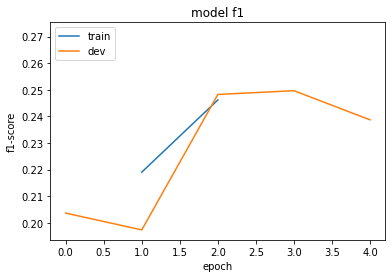

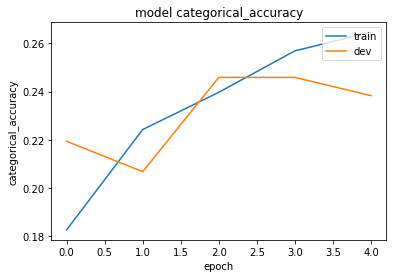

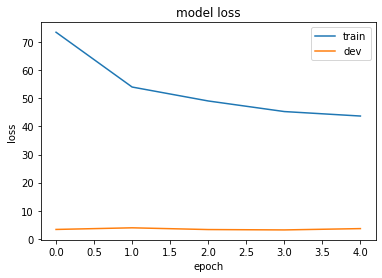

<IPython.core.display.Javascript object>

In [10]:
if RUN_STATE == "testing":
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [11]:
if RUN_STATE == "testing":
    score = model.evaluate(
        model_data["x_test"],
        model_data["y_test"],
        batch_size=best_model_params["batch_size"],
        verbose=1,
    )

    print("\nTest f1: %.4f" % (score[1]))
    print("\nTest categorical accuracy: %.4f" % (score[2]))

794/794 [==============================] - 15s 19ms/step

Test f1: 0.2505

Test categorical accuracy: 0.2322


<IPython.core.display.Javascript object>

### Visualize Prediction Perfomance  model

--------------------------------------------------------------------------------
Accuracy Score: 23.80%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       338
           1      0.000     0.000     0.000        35
           2      0.000     0.000     0.000        30
           3      0.000     0.000     0.000        20
           4      0.000     0.000     0.000        18
           5      0.000     0.000     0.000        12
           6      0.300     0.300     0.300        20
           7      0.215     0.979     0.353       143
           8      0.635     0.393     0.485        84
           9      0.333     0.062     0.105        64
          10      0.000     0.000     0.000        11
          11      0.000     0.000     0.000         5
       

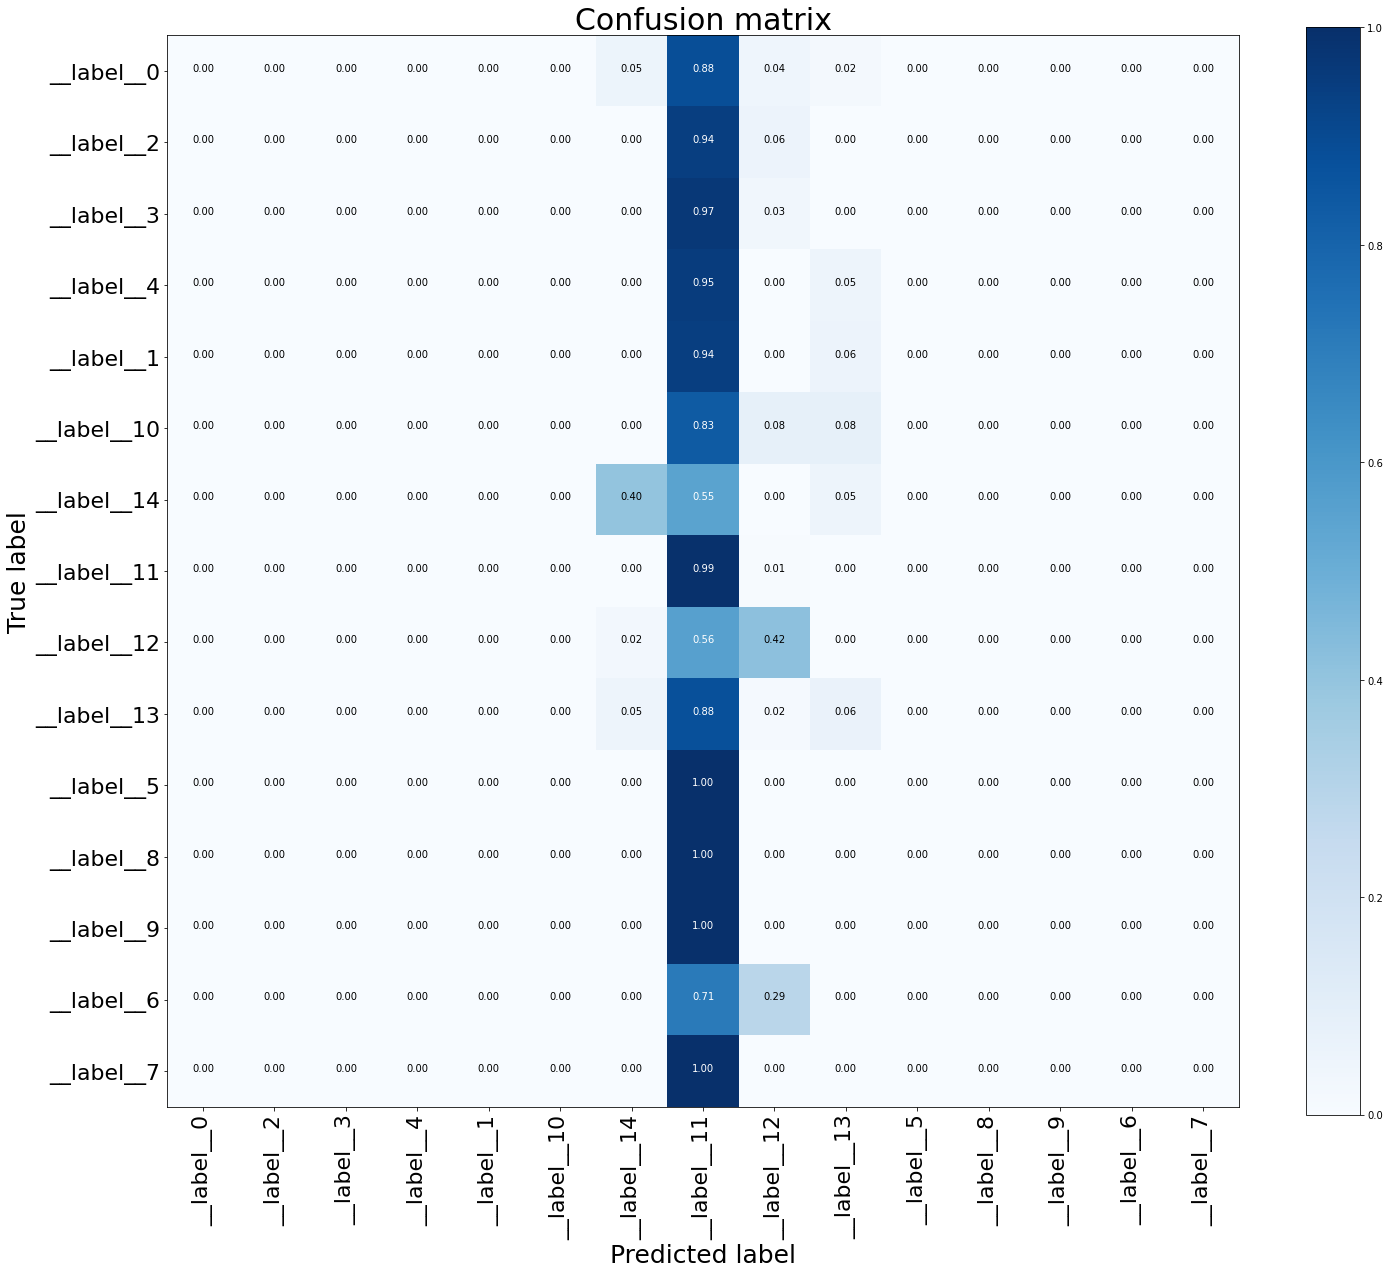

<IPython.core.display.Javascript object>

In [12]:
if RUN_STATE == "testing":
    import numpy as np
    from app.visualization import (
        plot_prediction_metrics,
        create_clf_report,
        plot_roc_curve,
        plot_precision_recall_curve,
        plot_confusion_matrix,
    )
    import matplotlib.pylab as plt

    prediction_val = model.predict(
        model_data["x_test"], batch_size=best_model_params["batch_size"]
    )

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
    y_true_processed = np.array([np.argmax(val) for val in model_data["y_test"]])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(
        model_data["y_test"],
        (prediction_val > 0.5).astype("int32"),
        y_true_processed,
        y_pred_processed,
    )

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)

### Multistack RNN with BiLSTM

In [8]:
TALOS_LSTM_DEEP_MULTI_LOG_FILENAME = 'talos_logs_multi_bilstm'
if RUN_STATE == 'testing': 
    TALOS_LSTM_DEEP_MULTI_LOG_FILENAME += '_test'


###### Production configuration
rnn_deep_lstm_multi_config = rnn_deep_lstm_config.copy()
rnn_deep_lstm_multi_config.update({
    "model_type": ["keras_deep_LSTM_multi_model"],
    "multistack_run": [True],
})

history_model_multi = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_multi_config,
                        fraction_limit=0.1,
                        print_params=True,
                        seed=(123),
                        experiment_name=TALOS_LSTM_DEEP_MULTI_LOG_FILENAME
                        )


TypeError: __init__() got an unexpected keyword argument 'dataset_name'

<IPython.core.display.Javascript object>

> Finds the best model configuration based for our RNN based on the highest value of the *val_f1*.

In [ ]:
report_talos_multi = ta.Reporting(history_model_multi)
best_model_idx = report_talos_multi.data['val_loss'].idxmax()
best_model_params_multi = report_talos_multi.data.loc[best_model_idx].to_dict()
best_model_params_multi

> Train a new RNN model based on the best Talos configuration.


In [ ]:
if RUN_STATE == 'testing':
    # Train and Load the best model of given the tuned featured model
    model_history_multi, model_multi = load_bi_lstm_model(model_data['x_train'],
                                                          model_data['y_train'],
                                                          model_data['x_train_dev'],
                                                          model_data['y_train_dev'],
                                                          best_model_params)

### Visualize Model History Scores

In [ ]:
if RUN_STATE == 'testing':
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history_multi)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [ ]:
if RUN_STATE == 'testing':
    score_multi = model_multi.evaluate(model_data['x_test'],
                                       model_data['y_test'],
                                       batch_size=best_model_params_multi['batch_size'],
                                       verbose=1)

    print('\nTest f1: %.4f' % (score_multi[1]))
    print('\nTest categorical accuracy: %.4f'% (score_multi[2]))

### Visualize Prediction Perfomance  model

In [ ]:
if RUN_STATE == 'testing':
    import numpy as np
    from app.visualization import (plot_prediction_metrics,
                                   create_clf_report,
                                   plot_roc_curve,
                                   plot_precision_recall_curve,
                                   plot_confusion_matrix)
    import matplotlib.pylab as plt

    prediction_val_multi = model_multi.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed_multi = np.array([np.argmax(val) for val in prediction_val_multi])
    y_true_processed_multi = np.array([np.argmax(val) for val in model_data['y_test']])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(model_data['y_test'], (prediction_val_multi > 0.5).astype('int32'),
                      y_true_processed_multi, y_pred_processed_multi)

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed_multi, y_pred_processed_multi, Classes)